In [2]:
library(Seurat)
library(dplyr)
library(cowplot)
library(harmony)
library(ggpubr)

In [3]:
setwd("/home/lhc/script/ARDS/neutrophilic_asthma/metadata")

data_PATH <- '/data1/lhc/experiment/ARDS/ARDS_raw_single_cell_results_1117/'
ding1_files <- paste(data_PATH, '/单样本/ding1/1.Basic_analysis/1.2.filtered_feature_bc_matrix/', sep='')
ding2_files <- paste(data_PATH, '/单样本/ding2/1.Basic_analysis/1.2.filtered_feature_bc_matrix/', sep='')

# Data loading

In [4]:
ding1_raw_data <- Read10X(data.dir = ding1_files)
ding1_raw_data <- CreateSeuratObject(counts = ding1_raw_data, project = "ding1_raw", min.cells = 3, min.features = 200)
ding1_raw_data

An object of class Seurat 
25177 features across 4799 samples within 1 assay 
Active assay: RNA (25177 features, 0 variable features)

In [5]:
ding2_raw_data <- Read10X(data.dir = ding2_files)
ding2_raw_data <- CreateSeuratObject(counts = ding2_raw_data, project = "ding2_raw", min.cells = 3, min.features = 200)
ding2_raw_data

An object of class Seurat 
23809 features across 6353 samples within 1 assay 
Active assay: RNA (23809 features, 0 variable features)

# Preprocessing and integration

## Filtering

In [6]:
ding1_raw_data[["percent.mt"]] <- PercentageFeatureSet(ding1_raw_data, pattern = "^MT-")
ding2_raw_data[["percent.mt"]] <- PercentageFeatureSet(ding2_raw_data, pattern = "^MT-")
ding1_raw_data <- subset(ding1_raw_data, subset = nFeature_RNA > 500 & nCount_RNA < 20000 & nCount_RNA > 1000 & percent.mt < 5)
ding2_raw_data <- subset(ding2_raw_data, subset = nFeature_RNA > 500 & nCount_RNA < 20000 & nCount_RNA > 1000 & percent.mt < 5)

In [7]:
ding1_used_genes <- rownames(ding1_raw_data@assays$RNA@data)[substr(rownames(ding1_raw_data@assays$RNA@data), 1,3) != 'MT-']
ding1_raw_data <- ding1_raw_data[ding1_used_genes]
ding2_used_genes <- rownames(ding2_raw_data@assays$RNA@data)[substr(rownames(ding2_raw_data@assays$RNA@data), 1,3) != 'MT-']
ding2_raw_data <- ding2_raw_data[ding2_used_genes]

## Integration by Harmony

In [8]:
ding_harmony_combined <- merge(ding1_raw_data, y = ding2_raw_data, add.cell.ids = c("ding1", "ding2"), project = "ding_combined")

ding_harmony_combined <- ding_harmony_combined %>% NormalizeData(verbose=F) %>%
FindVariableFeatures(verbose=F) %>% 
ScaleData(verbose=F) %>%  RunPCA(verbose=F)

ding_harmony_combined <- ding_harmony_combined %>% RunHarmony('orig.ident', verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [9]:
ding_harmony_combined <- ding_harmony_combined %>% RunUMAP(reduction = 'harmony', dims = 1:20, verbose=F) %>%
RunTSNE(reduction = 'harmony', dims = 1:20) %>% FindNeighbors(reduction = "harmony", dims = 1:20, verbose=F)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


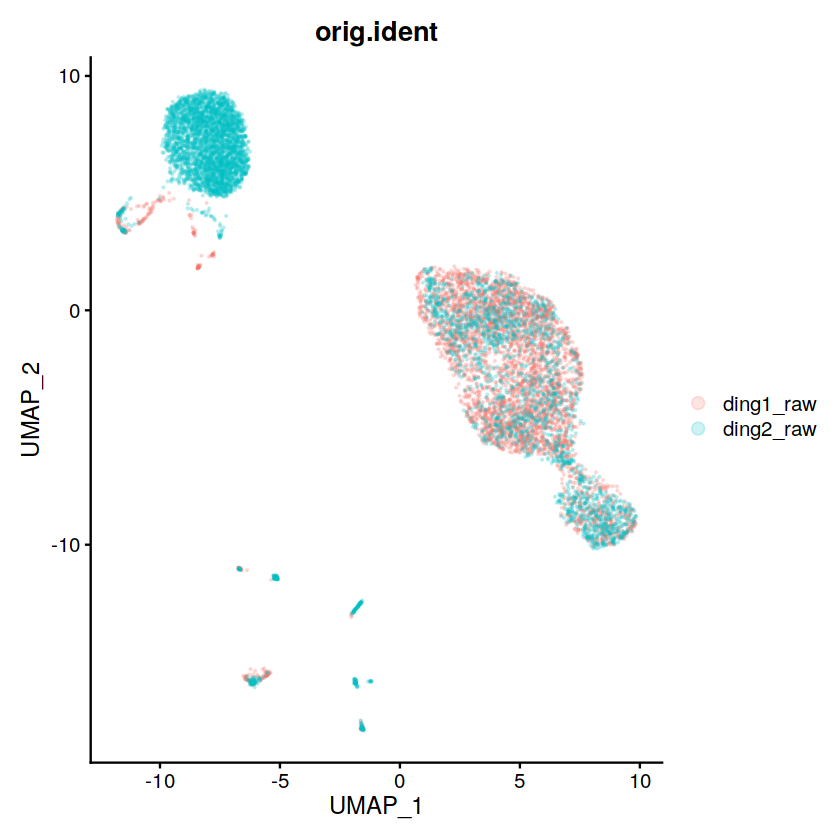

In [10]:
p <- DimPlot(ding_harmony_combined, reduction = "umap", group.by='orig.ident')
p[[1]]$layers[[1]]$aes_params$alpha = .2
p

# Cell-type identification

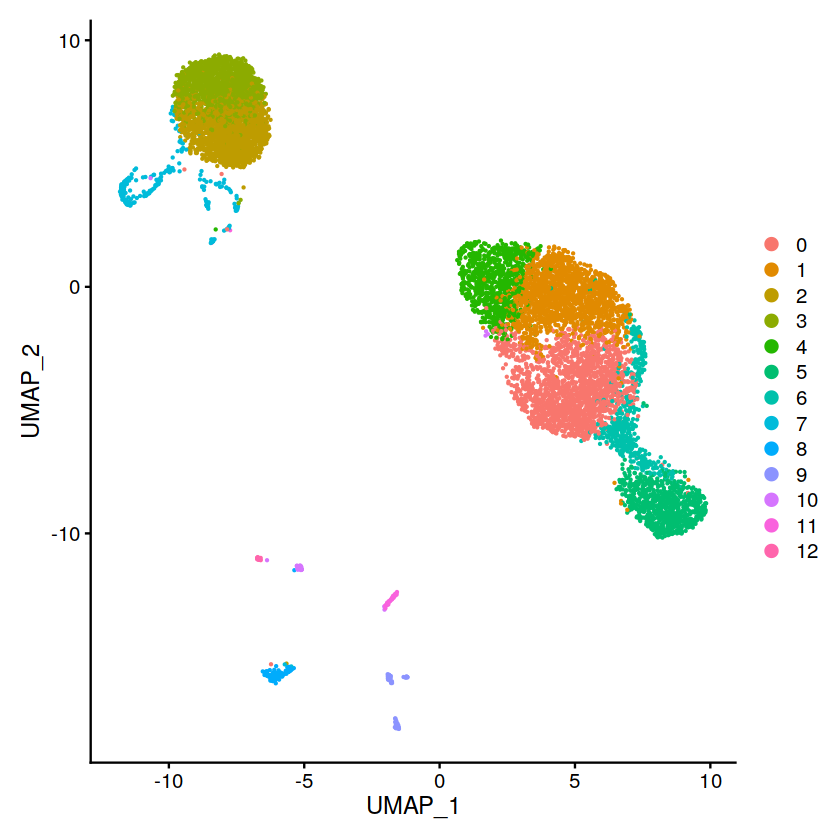

In [11]:
ding_harmony_combined <- ding_harmony_combined %>% FindClusters(resolution = 0.6, verbose=F)
DimPlot(ding_harmony_combined, reduction = "umap")

In [12]:
ding_harmony_combined@meta.data$plot = 0
ding_harmony_combined@meta.data[which(ding_harmony_combined@meta.data$RNA_snn_res.0.6 %in% c(2,3)),]$plot = 1

In [13]:
this_used_markers <- c('FCGR3B', 'CSF3R','CXCR2','BCL6','ANXA3','ALPL', # Neutrophils
                       'CST3', 'LYZ', 'CD68', 'CD163', # Macrophage
                       'CD3D','CD8A','TNFRSF4', # T cells
                       'KRT18','KRT8','KRT19' # Epithelial cells
                      )

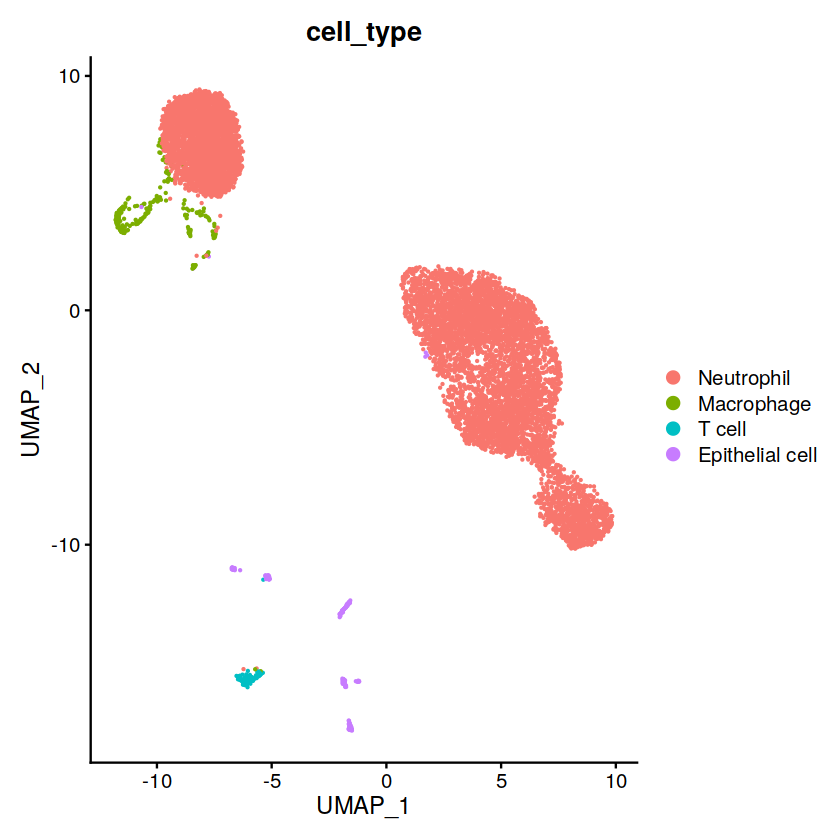

In [14]:
Idents(ding_harmony_combined) <- ding_harmony_combined@meta.data$RNA_snn_res.0.6
labeled_ding_harmony_combined <- RenameIdents(ding_harmony_combined,
                                     `0` = "Neutrophil",`1` = "Neutrophil",
                                   `2` = "Neutrophil",`3` = "Neutrophil",
                                   `4` = "Neutrophil",`5` = "Neutrophil",
                                   `6` = "Neutrophil",`7` = "Macrophage",
                                   `8` = "T cell",`9` = "Epithelial cell",
                                   `10` = "Epithelial cell",`11` = "Epithelial cell",
                                        `12` = "Epithelial cell")
labeled_ding_harmony_combined@meta.data['cell_type'] <- Idents(labeled_ding_harmony_combined)
DimPlot(labeled_ding_harmony_combined, group.by='cell_type')

Warning message:
“Scaling data with a low number of groups may produce misleading results”
Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



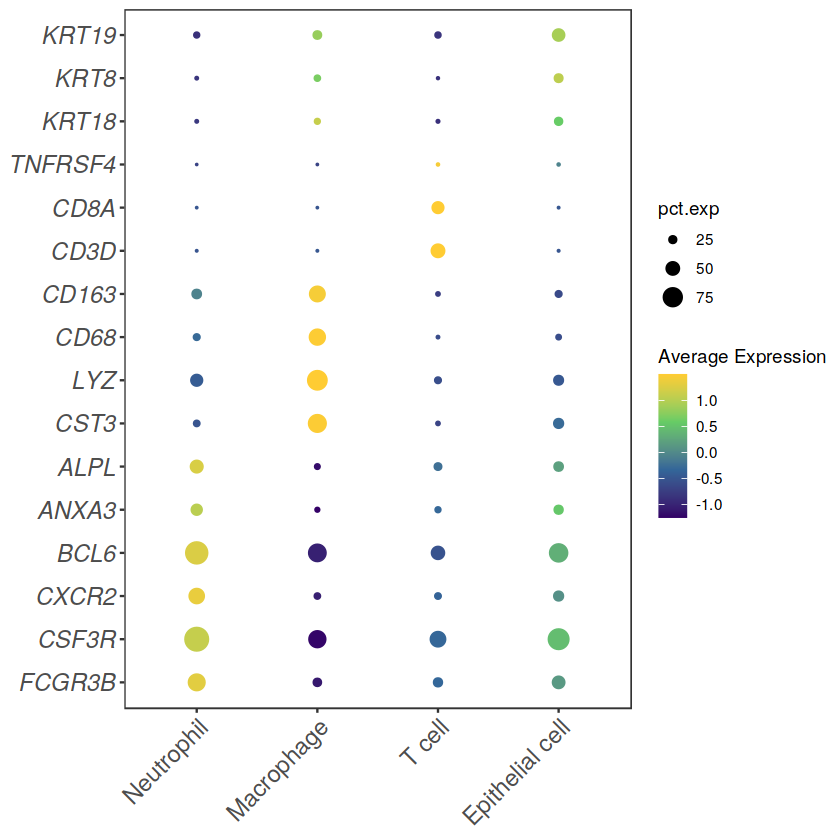

In [15]:
font = 14
DotPlot(labeled_ding_harmony_combined, features = this_used_markers)+coord_flip()+
  theme_bw()+
  theme(panel.grid = element_blank(), axis.text.x=element_text(hjust = 1,vjust=0.5))+
  labs(x=NULL,y=NULL)+guides(size=guide_legend(order=3))+
  scale_color_gradientn(values = seq(0,1,0.2),colours = c('#330066','#336699','#66CC66','#FFCC33'))+
  theme(axis.text.x =element_text(size=font, angle = 45, hjust = 1, vjust=1), 
        axis.text.y =element_text(size=font, face='italic'))

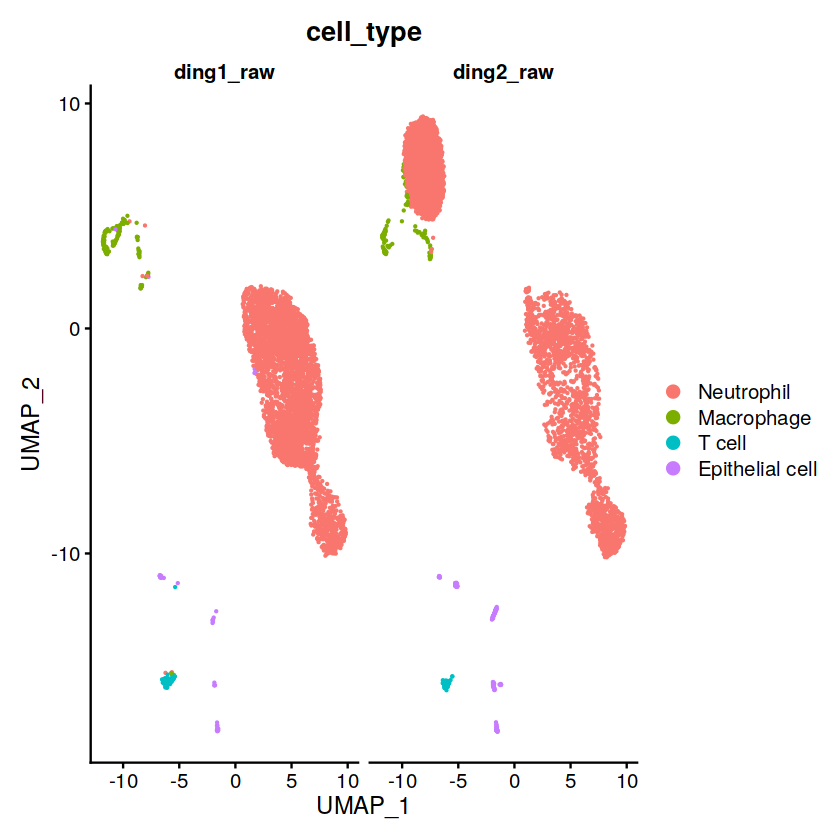

In [16]:
DimPlot(labeled_ding_harmony_combined, reduction = 'umap', group.by='cell_type', split.by = 'orig.ident',ncol = 2)

In [17]:
save(labeled_ding_harmony_combined, file = 'saved_Rdata/labeled_ding_harmony_combined_final_0314.Rdata')

# Neutrophil re-integration

In [18]:
neutrophil_merged_data <- labeled_ding_harmony_combined %>% subset(subset=cell_type=='Neutrophil')

In [19]:
neutrophil_merged_data <- neutrophil_merged_data %>% RunHarmony('orig.ident', verbose = FALSE)

Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is Seurat..ProjectDim.RNA.harmony; see ?make.names for more details on syntax validity”


In [20]:
neutrophil_merged_data <- neutrophil_merged_data %>% RunUMAP(reduction = 'harmony', dims = 1:20, verbose=F) %>%
RunTSNE(reduction = 'harmony', dims = 1:20) %>% FindNeighbors(reduction = "harmony", dims = 1:20, verbose=F)

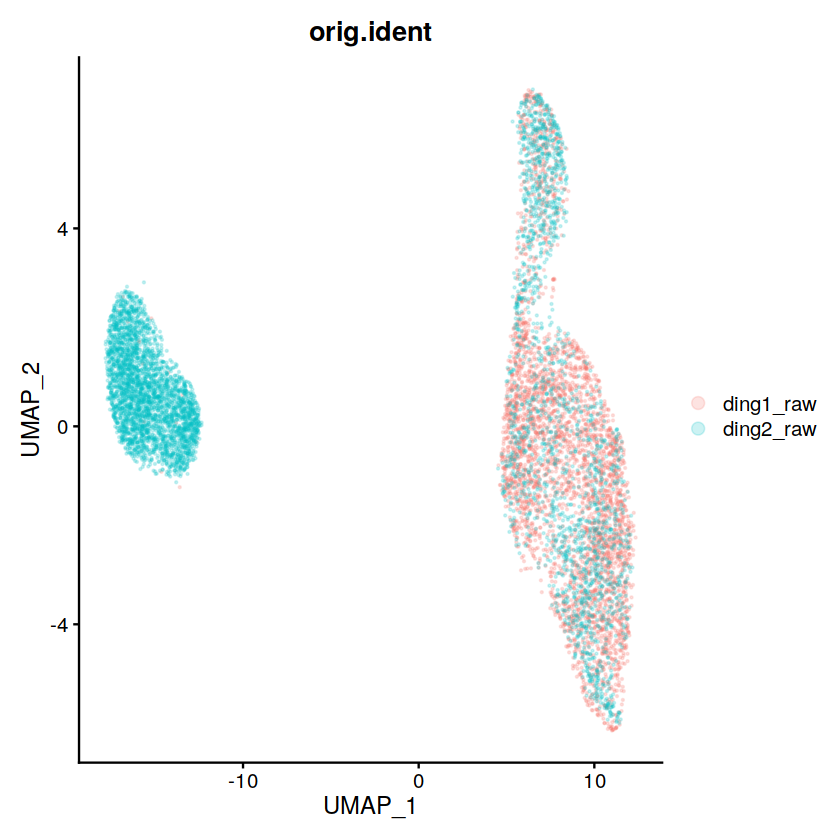

In [21]:
p <- DimPlot(neutrophil_merged_data, reduction = "umap", group.by='orig.ident')
p[[1]]$layers[[1]]$aes_params$alpha = .2
p

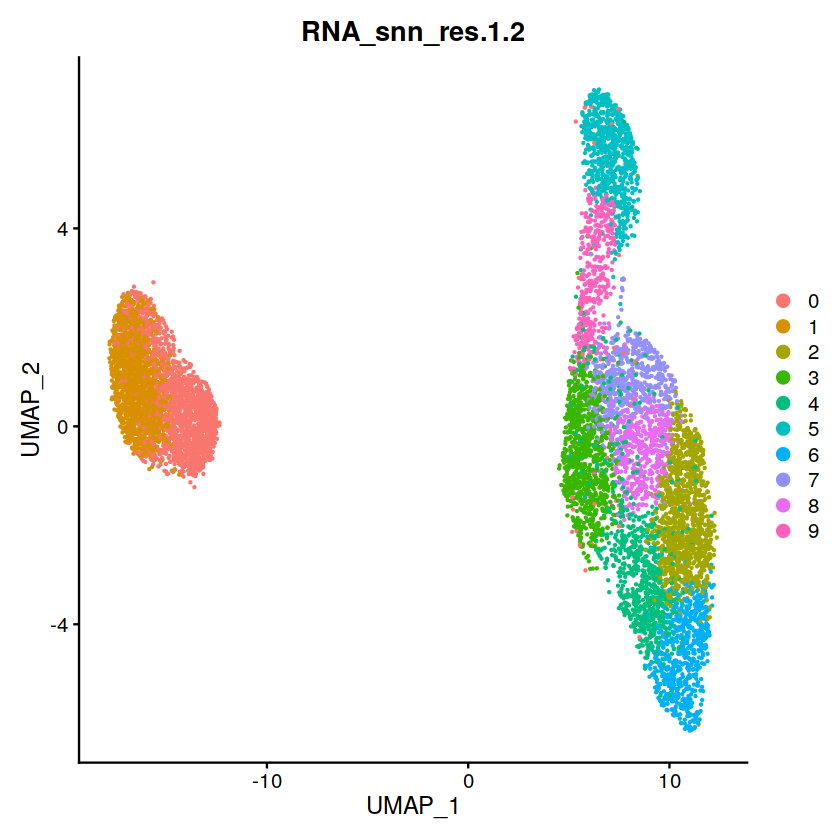

In [22]:
neutrophil_merged_data <- neutrophil_merged_data %>% FindClusters(resolution = 1.2, verbose=F)
DimPlot(neutrophil_merged_data, reduction = "umap", group.by='RNA_snn_res.1.2')

In [23]:
tmp <- neutrophil_merged_data %>% subset(subset = RNA_snn_res.1.2 %in% c(0,1))
cells_on_interest <- tmp@assays$RNA@data %>% colnames
neutrophil_merged_data@meta.data$on_interest = 0
neutrophil_merged_data@meta.data[cells_on_interest,]$on_interest = 1

In [24]:
Neu_subclustering_markers <- c('IL1B', 'CXCL8', 'CCL3', 'CCL4', # Inflammatory mature neutrophils (CCL4+), with high-level cytokines and chemokines
                                'CXCR4','CD63','VEGFA','CTSA','CTSD', # Progenitor neutrophils (CD63+)
                               'IL1RL2',
                               'S100A8', 'S100A9', 'S100A12','CXCR2', # Inflammatory mature neutrophils (S100A12+), with IFN-induced genes and calgranulins
                               'C1QB','C1QC','CD74','CTSB','CTSL','APOE' # Hybrid neutrophils (CD74+), with macrophage-like characteristics
                              )

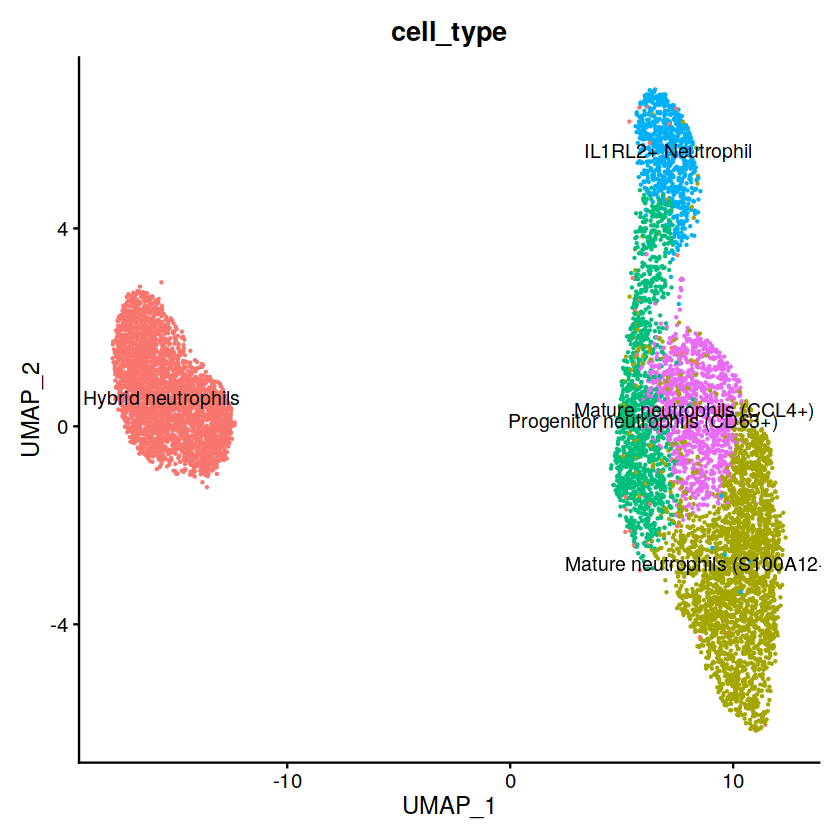

In [25]:
Idents(neutrophil_merged_data) <- neutrophil_merged_data@meta.data$RNA_snn_res.1.2
labeled_neutrophil_merged_data <- RenameIdents(neutrophil_merged_data,
                                     `0` = "Hybrid neutrophils",`1` = "Hybrid neutrophils",
                                   `2` = "Mature neutrophils (S100A12+CXCR2+)",`3` = "Progenitor neutrophils (CD63+)",
                                   `4` = "Mature neutrophils (S100A12+CXCR2+)",`5` = "IL1RL2+ Neutrophil",
                                   `6` = "Mature neutrophils (S100A12+CXCR2+)",`7` = "Mature neutrophils (CCL4+)",
                                   `8` = "Mature neutrophils (CCL4+)",`9` = "Progenitor neutrophils (CD63+)")
labeled_neutrophil_merged_data@meta.data['cell_type'] <- Idents(labeled_neutrophil_merged_data)
DimPlot(labeled_neutrophil_merged_data, group.by='cell_type', label = TRUE) + NoLegend()

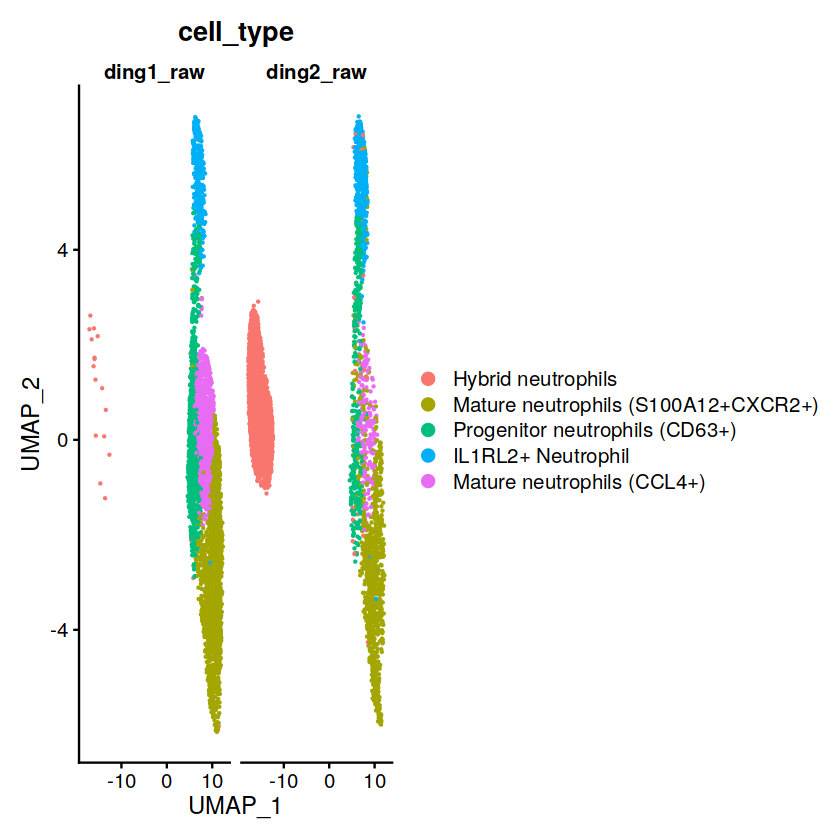

In [26]:
DimPlot(labeled_neutrophil_merged_data, reduction = 'umap', group.by='cell_type', split.by = 'orig.ident',ncol = 2)

In [27]:
my_levels <- c("Hybrid neutrophils", "Mature neutrophils (S100A12+CXCR2+)", 
               "IL1RL2+ Neutrophil", "Progenitor neutrophils (CD63+)", "Mature neutrophils (CCL4+)")
Idents(labeled_neutrophil_merged_data) <- factor(Idents(labeled_neutrophil_merged_data), levels= my_levels)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



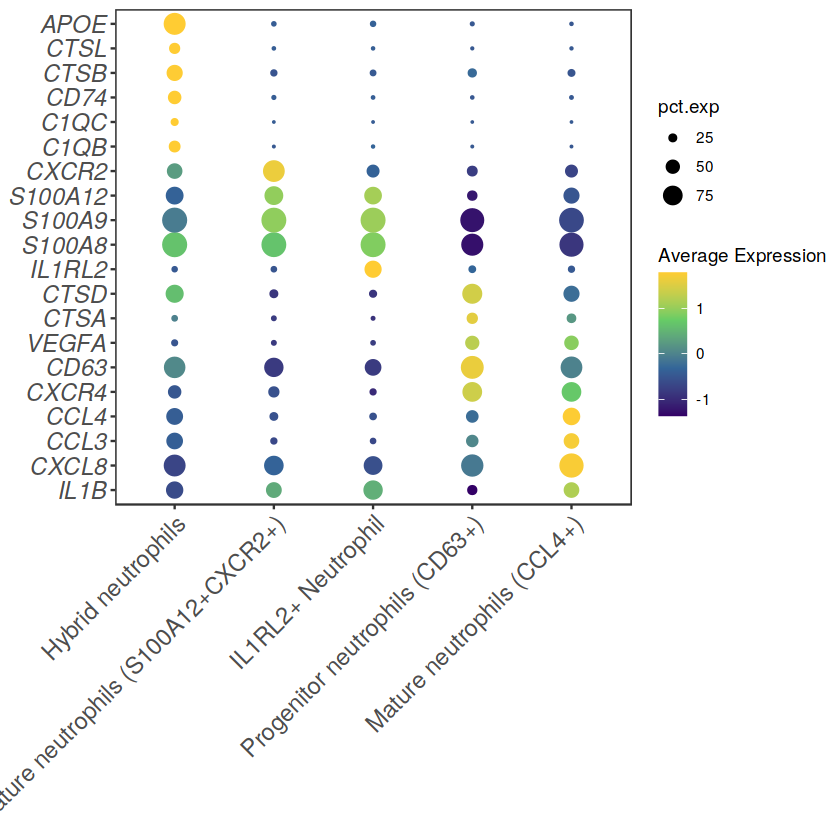

In [28]:
font = 14
DotPlot(labeled_neutrophil_merged_data, features = Neu_subclustering_markers)+coord_flip()+
  theme_bw()+
  labs(x=NULL,y=NULL)+guides(size=guide_legend(order=3))+
  scale_color_gradientn(values = seq(0,1,0.2),colours = c('#330066','#336699','#66CC66','#FFCC33')) +
  theme(panel.grid = element_blank(),
        axis.text.x = element_text(size=font, angle = 45, hjust = 1, vjust=1),     
        axis.text.y = element_text(size=font, face='italic'))

In [29]:
save(labeled_neutrophil_merged_data, file = 'saved_Rdata/labeled_neutrophil_harmony_combined_final_0314.Rdata')

# Data during the remission phase 

In [31]:
ding2 <- ding2_raw_data %>% NormalizeData(verbose=F) %>% FindVariableFeatures %>%
ScaleData(verbose=F) %>%  RunPCA(verbose=F) %>%
RunUMAP(reduction = "pca", dim=1:20, verbose=F) %>% 
FindNeighbors(reduction = "pca", verbose=F)

In [32]:
tmp <- labeled_ding_harmony_combined@meta.data %>% filter(orig.ident=='ding2_raw')
rownames(tmp) <- rownames(tmp) %>% strsplit('_') %>% lapply(function(x) x[2]) %>% unlist
ding2@meta.data <- tmp[rownames(ding2@meta.data),]

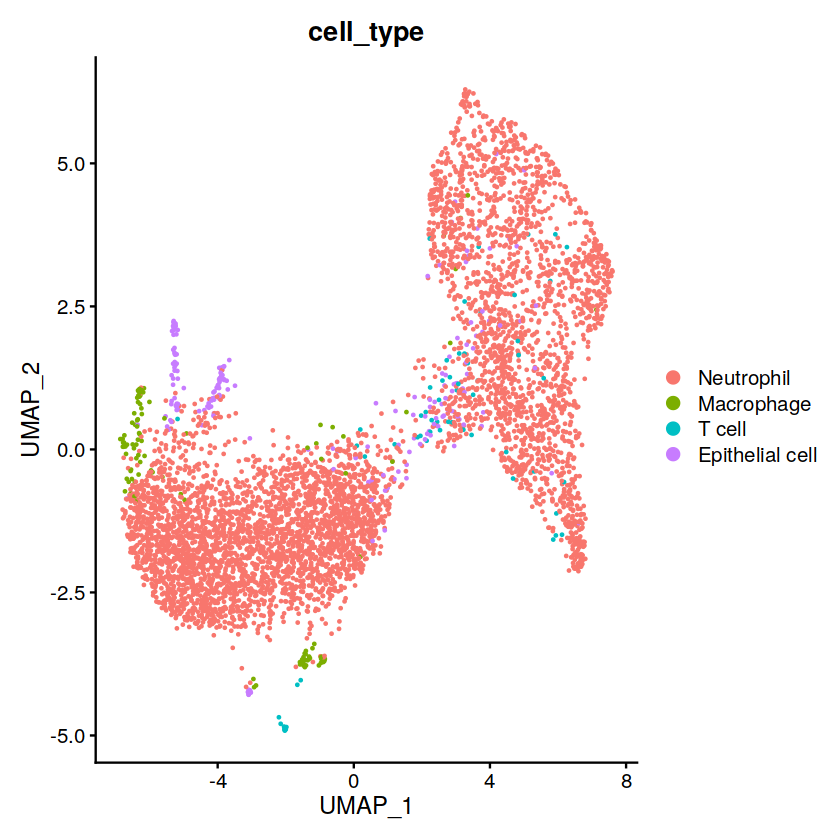

In [33]:
DimPlot(ding2, reduction = "umap", group.by='cell_type')

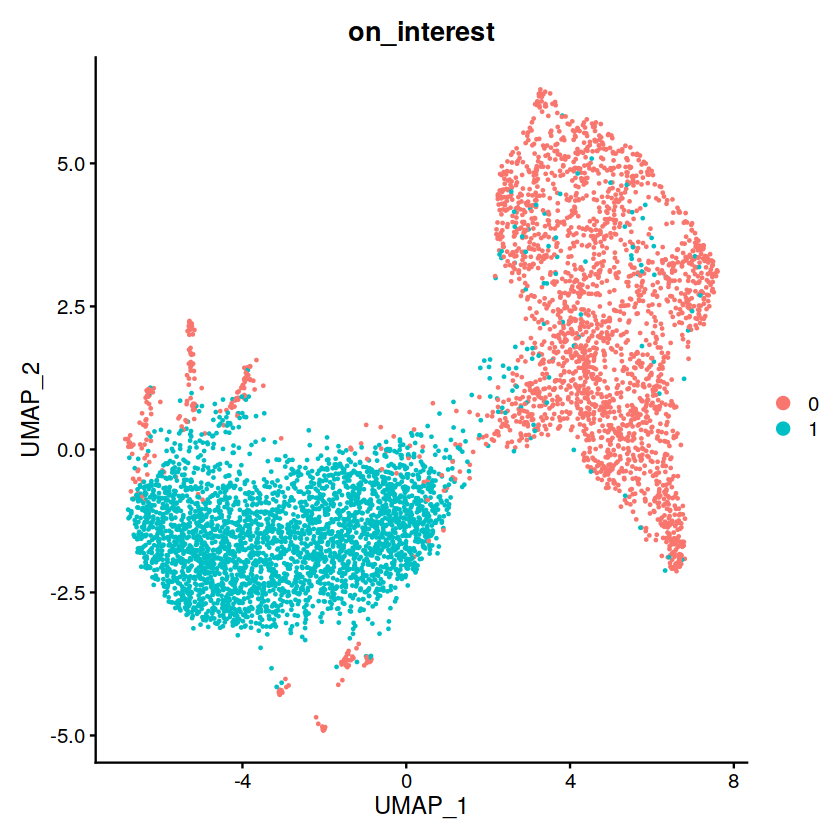

In [34]:
tmp <- ding_harmony_combined %>% subset(subset = RNA_snn_res.0.6 %in% c(2,3))
cells_on_interest <- tmp@assays$RNA@data %>% colnames %>% strsplit('_') %>% lapply(function(x) x[2]) %>% unlist
                                                                                   
cells_on_interest <-  cells_on_interest %>% intersect(row.names(ding2@meta.data))
ding2@meta.data$on_interest = 0
ding2@meta.data[cells_on_interest,]$on_interest = 1
DimPlot(ding2, reduction = "umap", group.by='on_interest')

In [ ]:
save(ding2, file = 'saved_Rdata/labeled_ding2_0314.Rdata')